### Import and Read The Data

In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [154]:
import itertools

In [155]:
import warnings
warnings.filterwarnings("ignore")

In [156]:
random_seed = 42

In [157]:
sns.set_theme(style="darkgrid", font_scale=1, rc={"axes.titlesize":18})

In [158]:
df = pd.read_csv("../data/external/Mall_Customers.csv")

In [159]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [160]:
df.shape

(200, 5)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [162]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### EDA

In [163]:
df.drop("CustomerID", axis=1, inplace=True)

In [164]:
df_numeric = df.select_dtypes(include="int64")

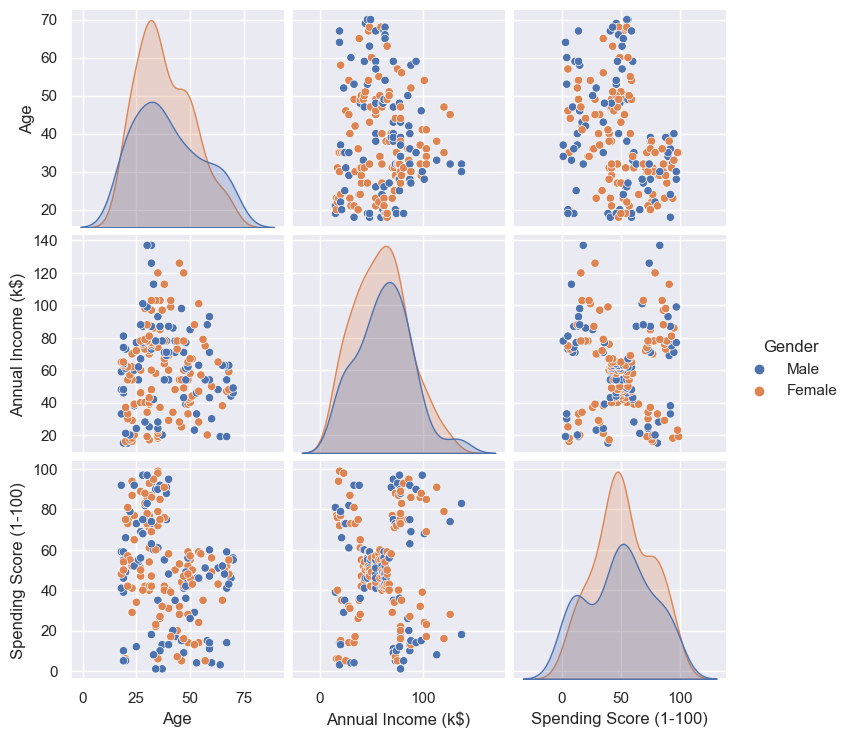

In [165]:
sns.pairplot(data=df, hue="Gender")

Based on the pairplot above, the scatter plot of "Annual Income" vs "Spending Score" appears to form a good cluster

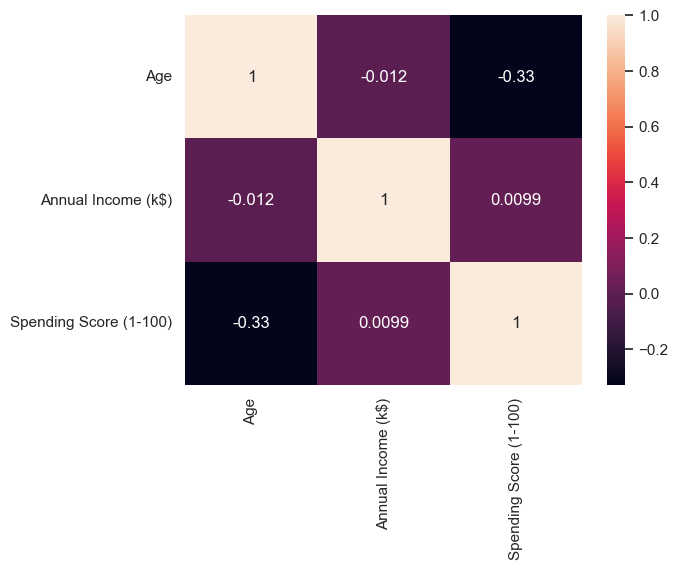

In [166]:
sns.heatmap(df_numeric.corr(), annot= True)
plt.show()

In [167]:
df_numeric.columns

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [168]:
column_combinations = list(itertools.combinations(df_numeric.columns, 2))


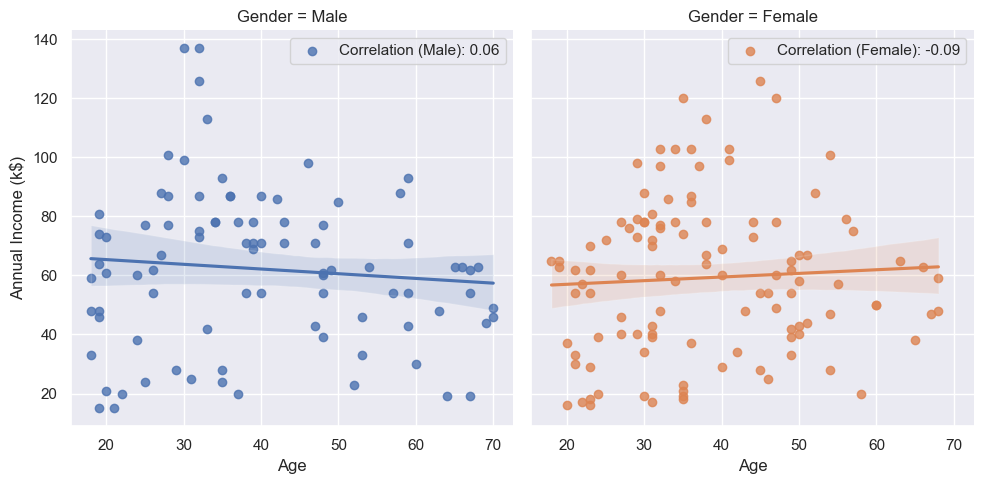

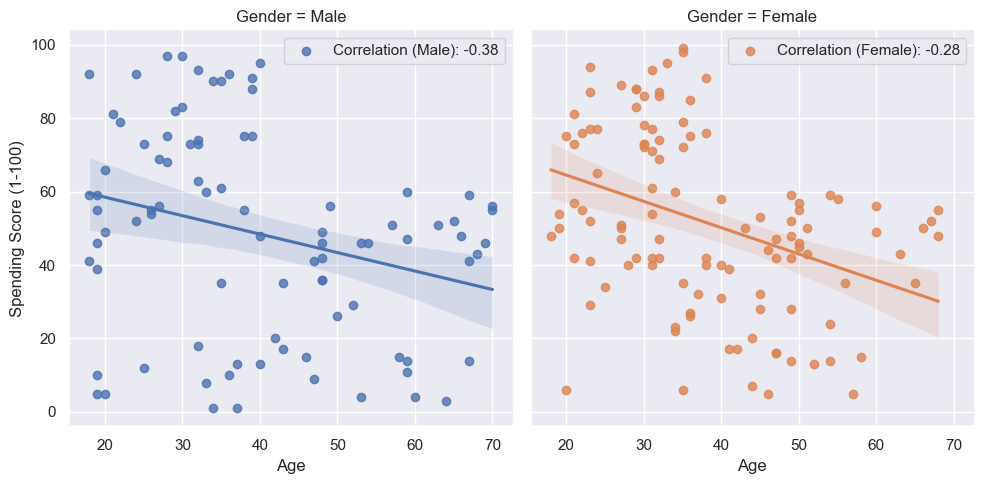

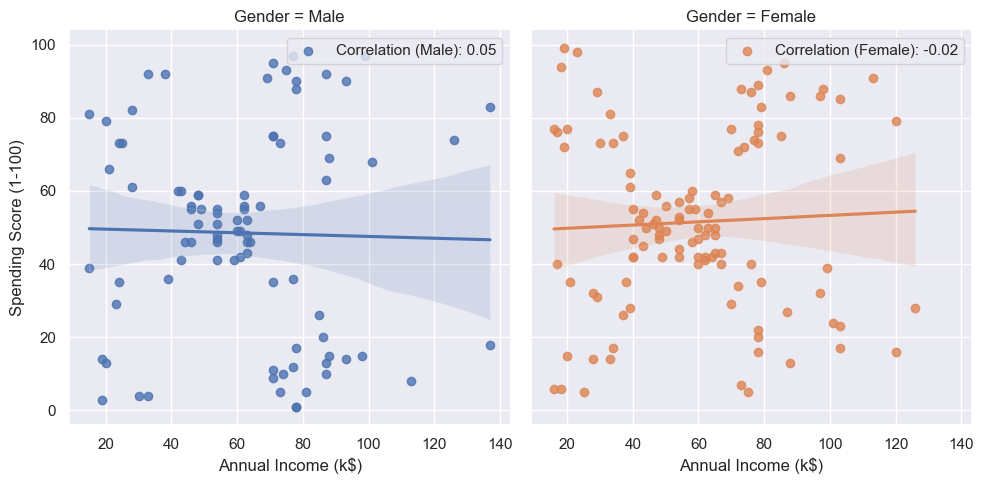

In [169]:
for x, y in column_combinations:
    g = sns.lmplot(x=x, y=y, hue="Gender", col="Gender", data=df)  

    correlations = df.groupby("Gender")[[x, y]].corr().values[::2]

    for i, corr in enumerate(correlations):
        correlation_value = corr[1]  
        legend_label = f'Correlation ({df["Gender"].unique()[i]}): {correlation_value:.2f}'
        
        g.axes[0][i].legend([legend_label], loc='upper right')
        
    plt.show()


We observed a potential negative correlation of around -0.28 and -0.38 between Age and spending score

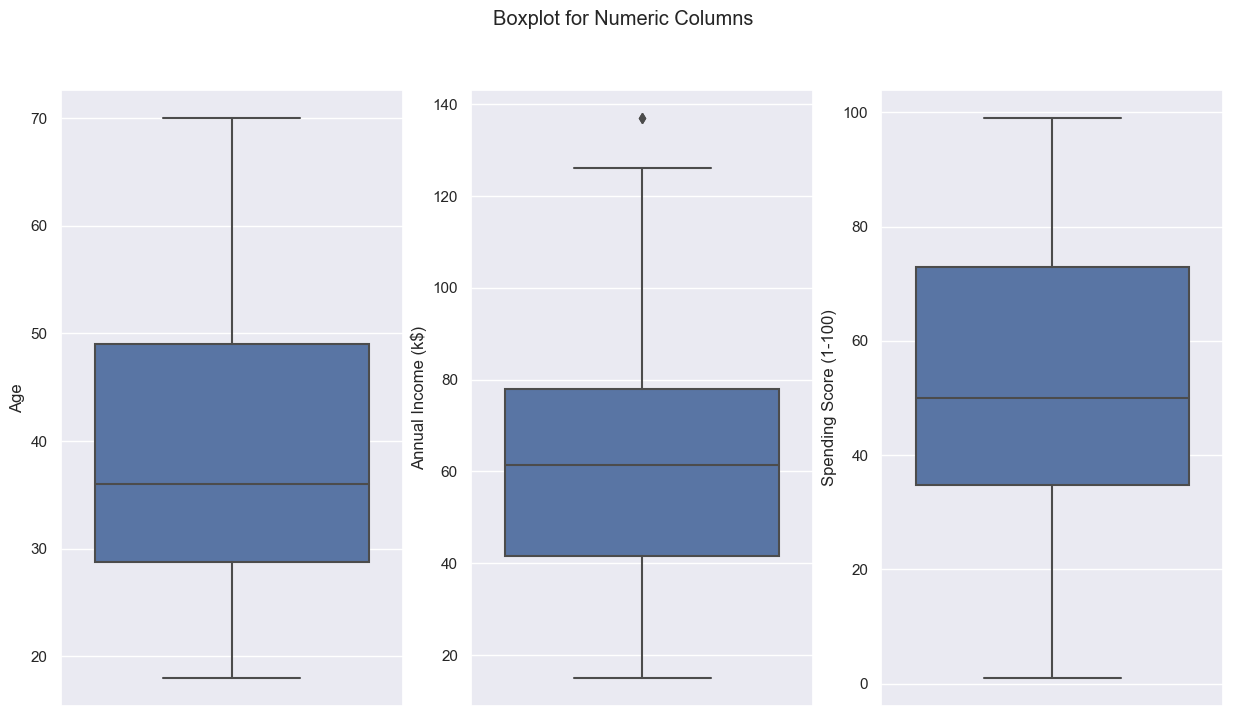

In [170]:
fig, ax = plt.subplots(nrows=1, ncols=len(df_numeric.columns), figsize = (15,8))

for i,column in enumerate(df_numeric.columns):
    sns.boxplot(data=df, y=column, ax=ax[i])

plt.suptitle("Boxplot for Numeric Columns")
plt.show()

In [171]:
def add_values_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x()+p.get_width()/2.,p.get_height()), ha = "center", va="center", xytext=(0,5), fontsize=12, color="black",textcoords='offset points')

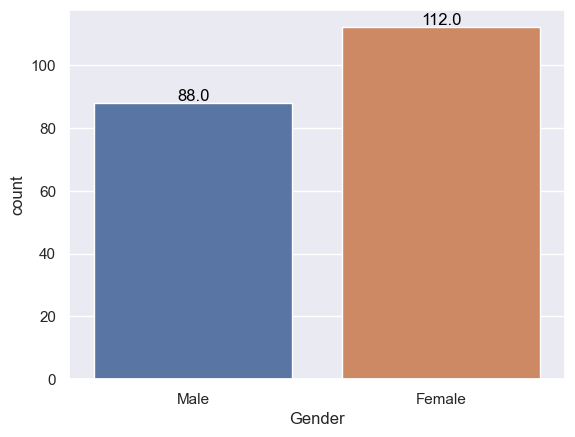

In [172]:
ax = sns.countplot(data = df, x="Gender")
add_values_labels(ax)

plt.show()

### Data Cleaning

We remove the outliers, especially in the Annual Income column, based on the distribution plot

In [173]:
q1 = df_numeric["Annual Income (k$)"].quantile(0.25)
q3 = df_numeric["Annual Income (k$)"].quantile(0.75)

iqr = q3 - q1
upper_bound = q3 + 1.5*iqr

df_numeric_cleaned = df_numeric[df_numeric["Annual Income (k$)"]<=upper_bound]


In [174]:
df_numeric_cleaned.shape

(198, 3)

Total data is from 200 to 198 data

### Modelling

In [175]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [176]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numeric_cleaned)

#### Clustering Age vs Annual Income

In [177]:
inertias = []

for i in range(1,8):
    km = KMeans(n_clusters=i, random_state=random_seed)
    km.fit(df_scaled[:,:2])
    inertias.append(km.inertia_)

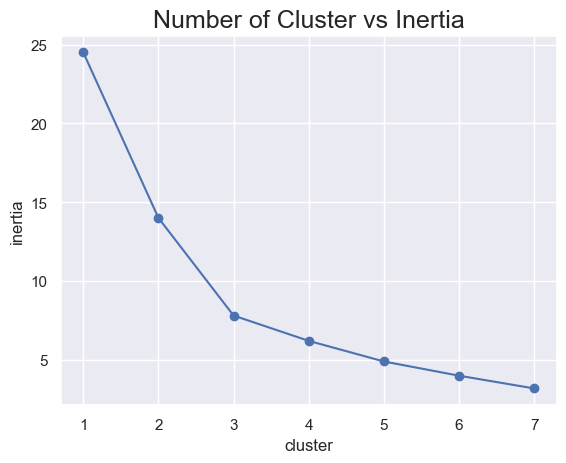

In [178]:
plt.plot(range(1,8),inertias, marker="o")

plt.title("Number of Cluster vs Inertia")
plt.xlabel("cluster")
plt.ylabel("inertia")

plt.show()

In [179]:
km = KMeans(n_clusters=3, random_state=random_seed)
km.fit(df_scaled[:,:2])

KMeans(n_clusters=3, random_state=42)

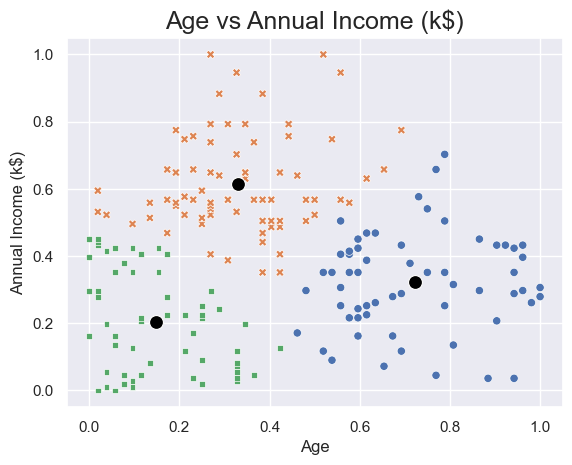

In [180]:
centroids = km.cluster_centers_
label = km.labels_

sns.scatterplot(x=df_scaled[:,0], y=df_scaled[:,1], hue=label, legend=False, style=label, palette="deep")
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], s = 100, c="black")
plt.title("Age vs Annual Income (k$)")
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")

plt.show()

#### Age vs Spending Score (1-100)

In [181]:
inertias = []

for i in range(1,11):
    km = KMeans(n_clusters=i, random_state=random_seed)
    km.fit(df_scaled[:,[0,2]])
    inertias.append(km.inertia_)

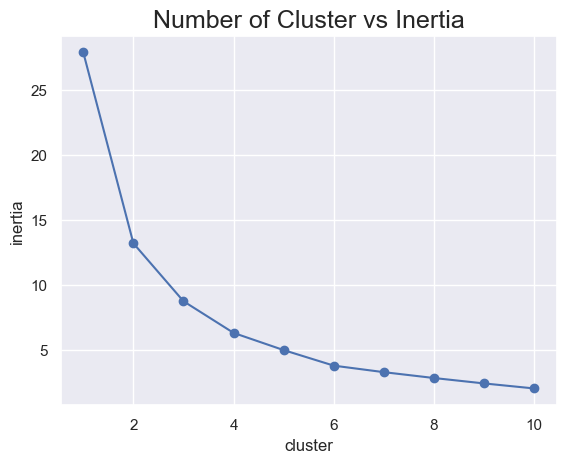

In [182]:
plt.plot(range(1,11),inertias, marker="o")

plt.title("Number of Cluster vs Inertia")
plt.xlabel("cluster")
plt.ylabel("inertia")

plt.show()

In [183]:
km = KMeans(n_clusters=4, random_state=random_seed)
km.fit(df_scaled[:,[0,2]])

KMeans(n_clusters=4, random_state=42)

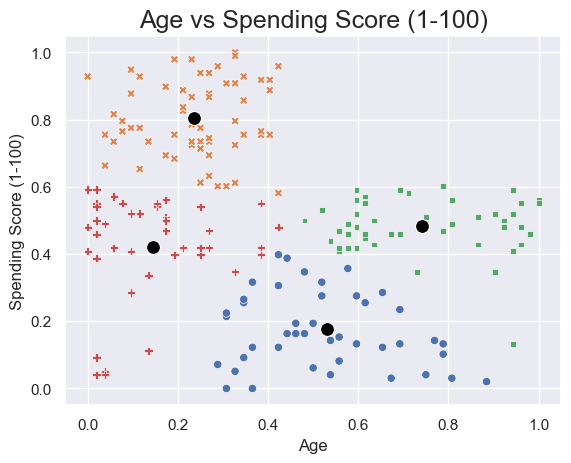

In [184]:
centroids = km.cluster_centers_
label = km.labels_

sns.scatterplot(x=df_scaled[:,0], y=df_scaled[:,2], hue=label, legend=False, style=label, palette="deep")
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], s = 100, c="black")
plt.title("Age vs Spending Score (1-100)")
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")

plt.show()

#### Annual Income vs Spending Score (1-100)

In [185]:
inertias = []

for i in range(1,11):
    km = KMeans(n_clusters=i, random_state=random_seed)
    km.fit(df_scaled[:,[1,2]])
    inertias.append(km.inertia_)

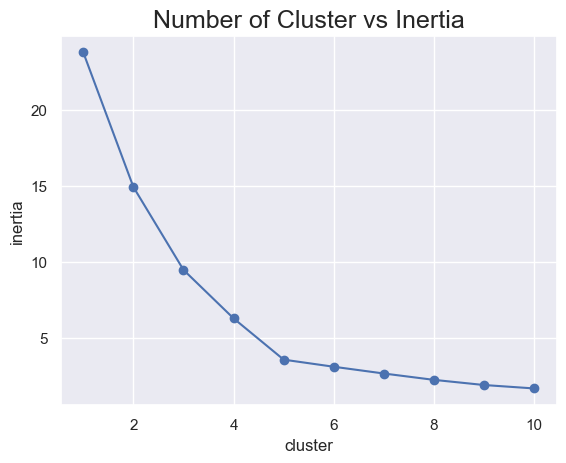

In [186]:
plt.plot(range(1,11),inertias, marker="o")

plt.title("Number of Cluster vs Inertia")
plt.xlabel("cluster")
plt.ylabel("inertia")

plt.show()

In [187]:
km = KMeans(n_clusters=5, random_state=random_seed)
km.fit(df_scaled[:,[1,2]])

KMeans(n_clusters=5, random_state=42)

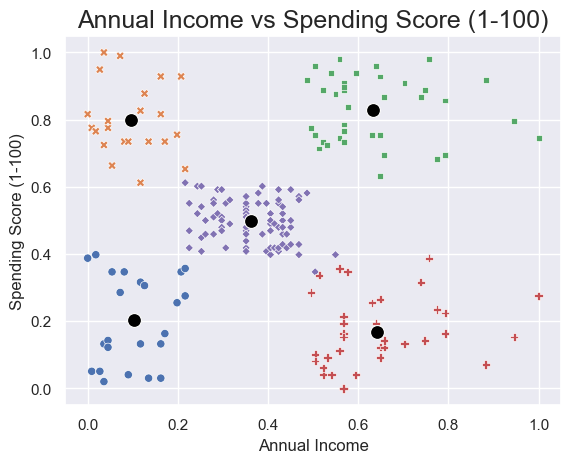

In [188]:
centroids = km.cluster_centers_
label = km.labels_

# Your existing scatterplot code
sns.scatterplot(x=df_scaled[:,1], y=df_scaled[:,2], hue=label, legend=False, style=label, palette="deep")
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], s = 100, c="black")
plt.title("Annual Income vs Spending Score (1-100)")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score (1-100)")


plt.show()


#### All of The Numeric Feature

In [200]:
inertias = []

for i in range(1,11):
    km = KMeans(n_clusters=i, random_state=random_seed)
    km.fit(df_scaled)
    inertias.append(km.inertia_)

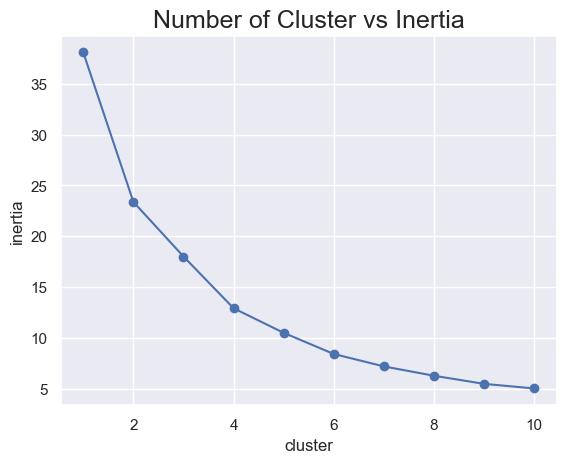

In [201]:
plt.plot(range(1,11),inertias, marker="o")

plt.title("Number of Cluster vs Inertia")
plt.xlabel("cluster")
plt.ylabel("inertia")

plt.show()

##### Silhoutte Analysis

To overcome the difficulty of unclear visibility of the elbow point, silhouette analysis can be utilized.

For n_clusters = 3 The average silhouette_score is : 0.3607919604410471
For n_clusters = 4 The average silhouette_score is : 0.3645467568345949
For n_clusters = 5 The average silhouette_score is : 0.4128428517802903
For n_clusters = 6 The average silhouette_score is : 0.42918876171699133
For n_clusters = 7 The average silhouette_score is : 0.42371236995917855
For n_clusters = 8 The average silhouette_score is : 0.40888476488116854


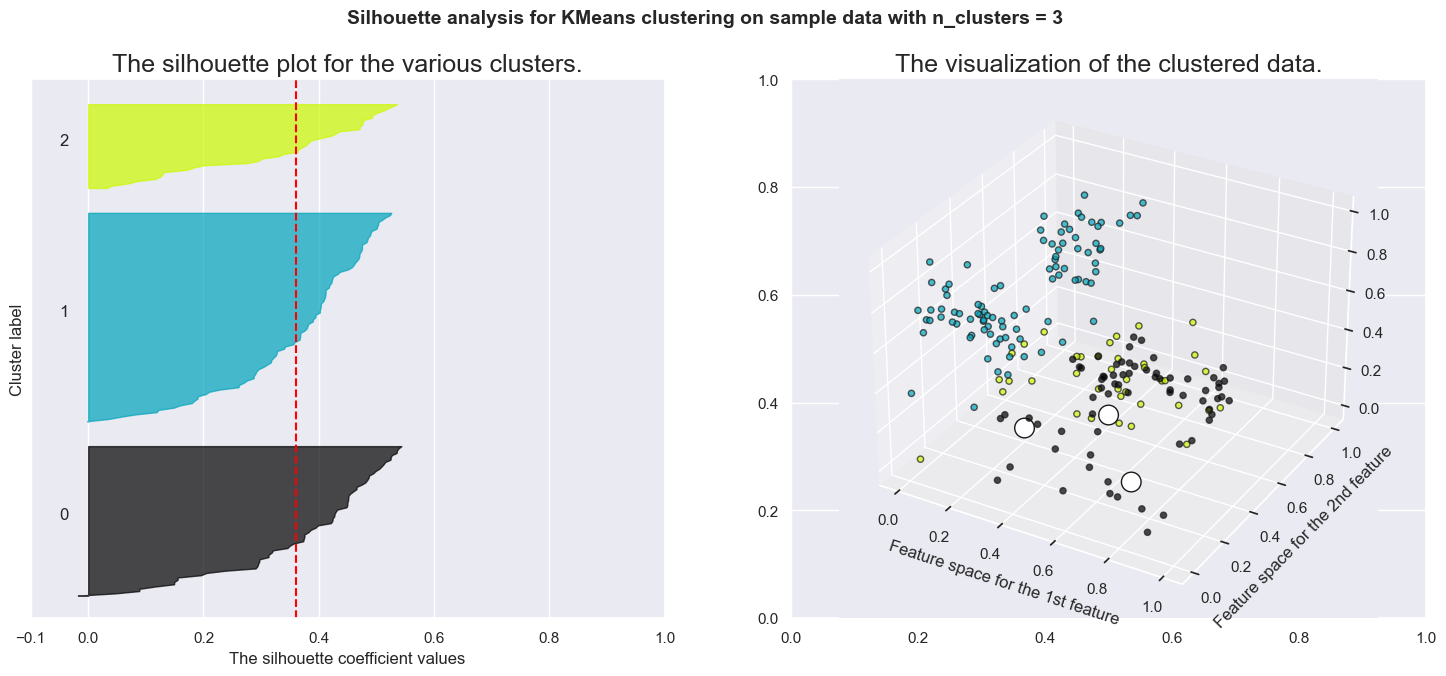

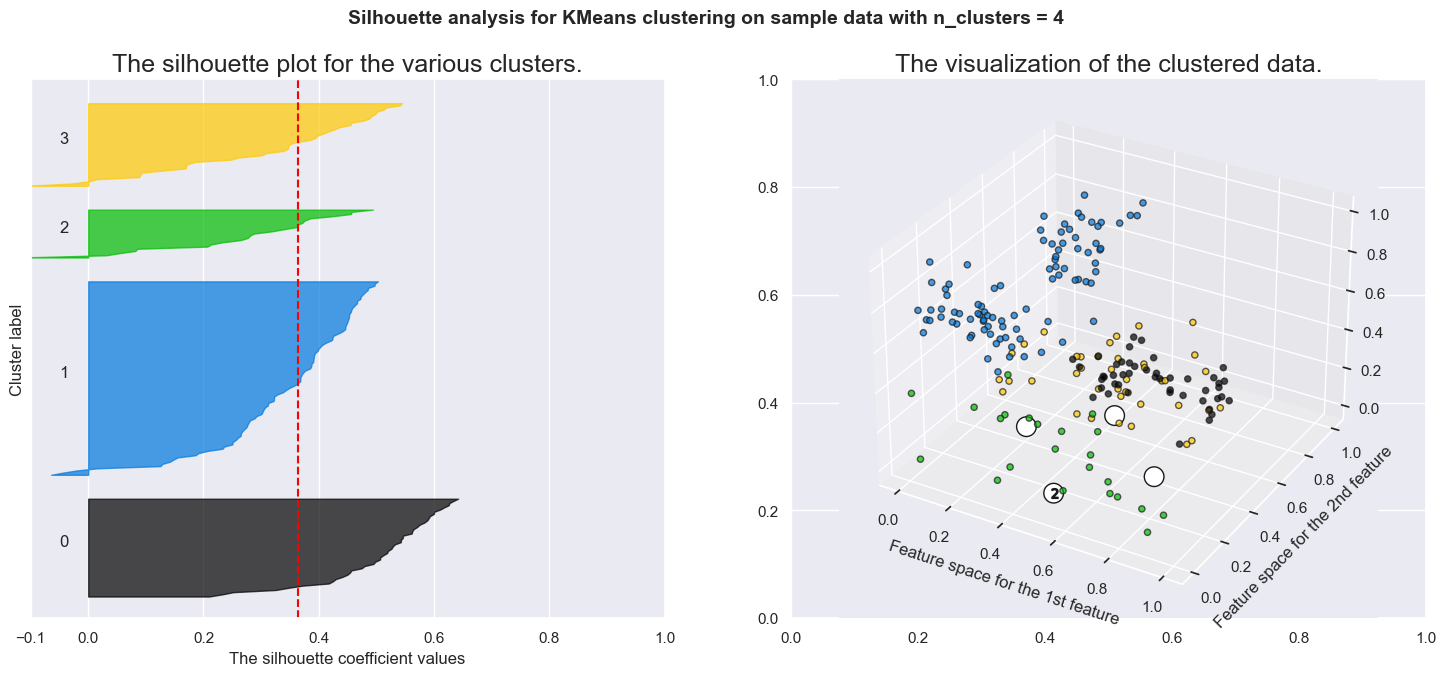

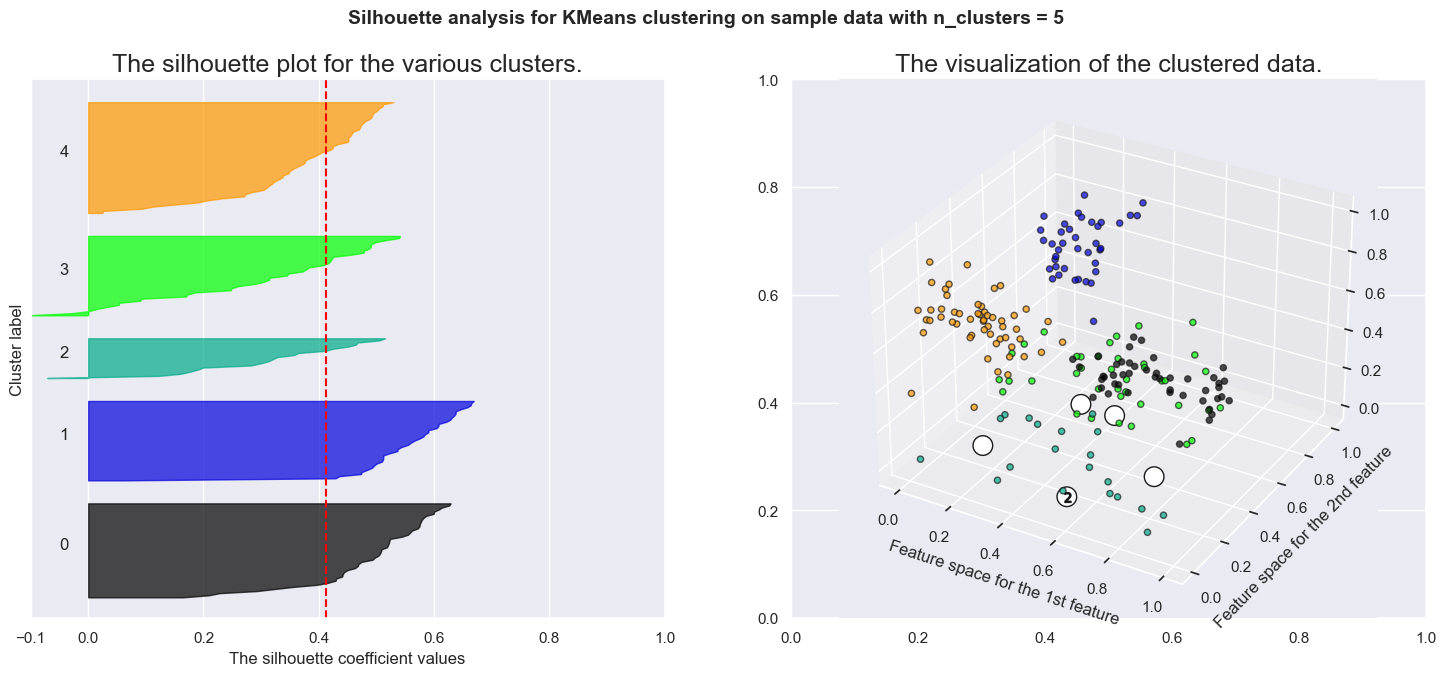

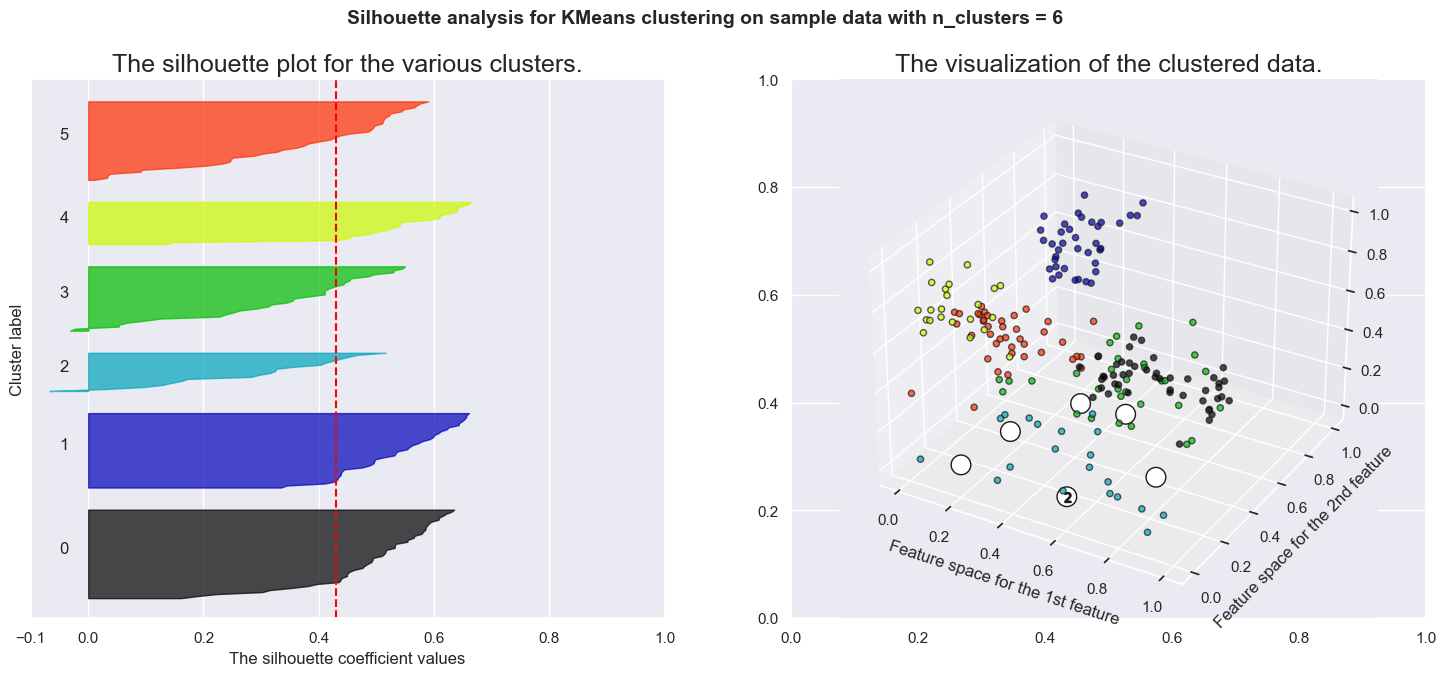

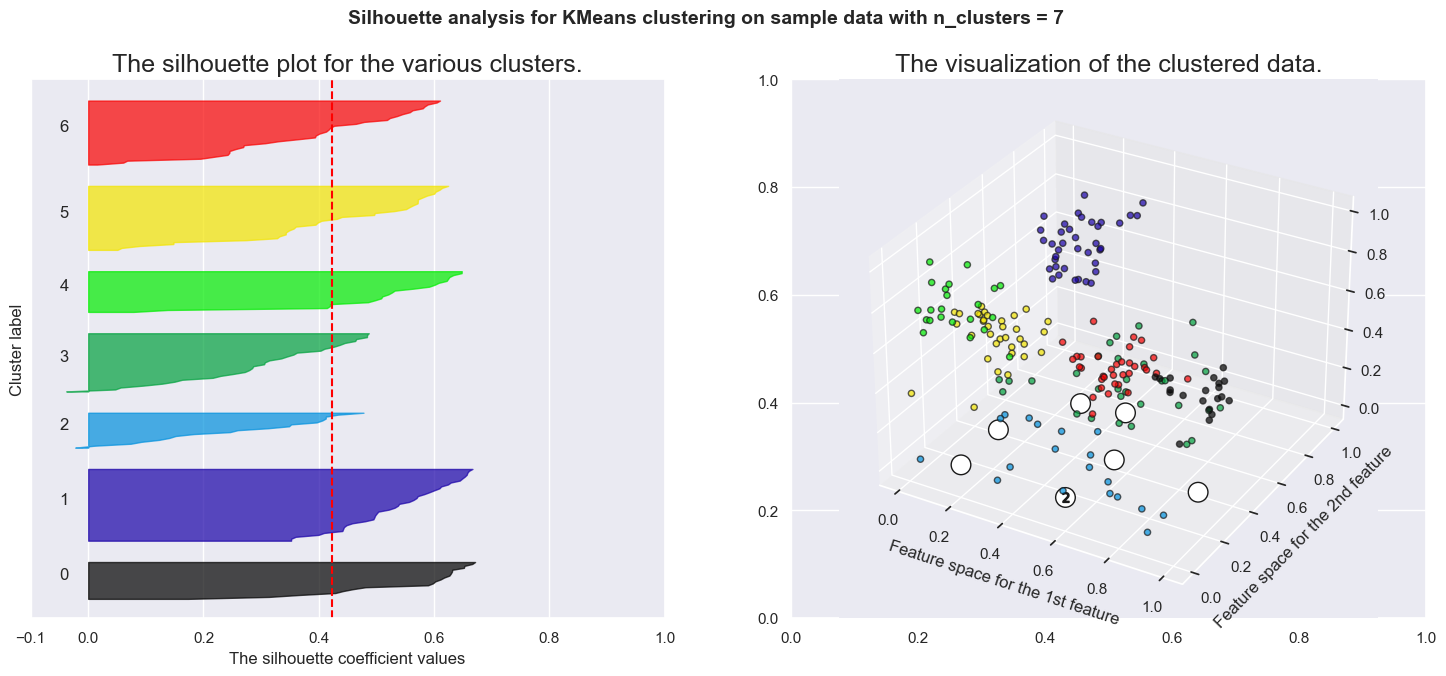

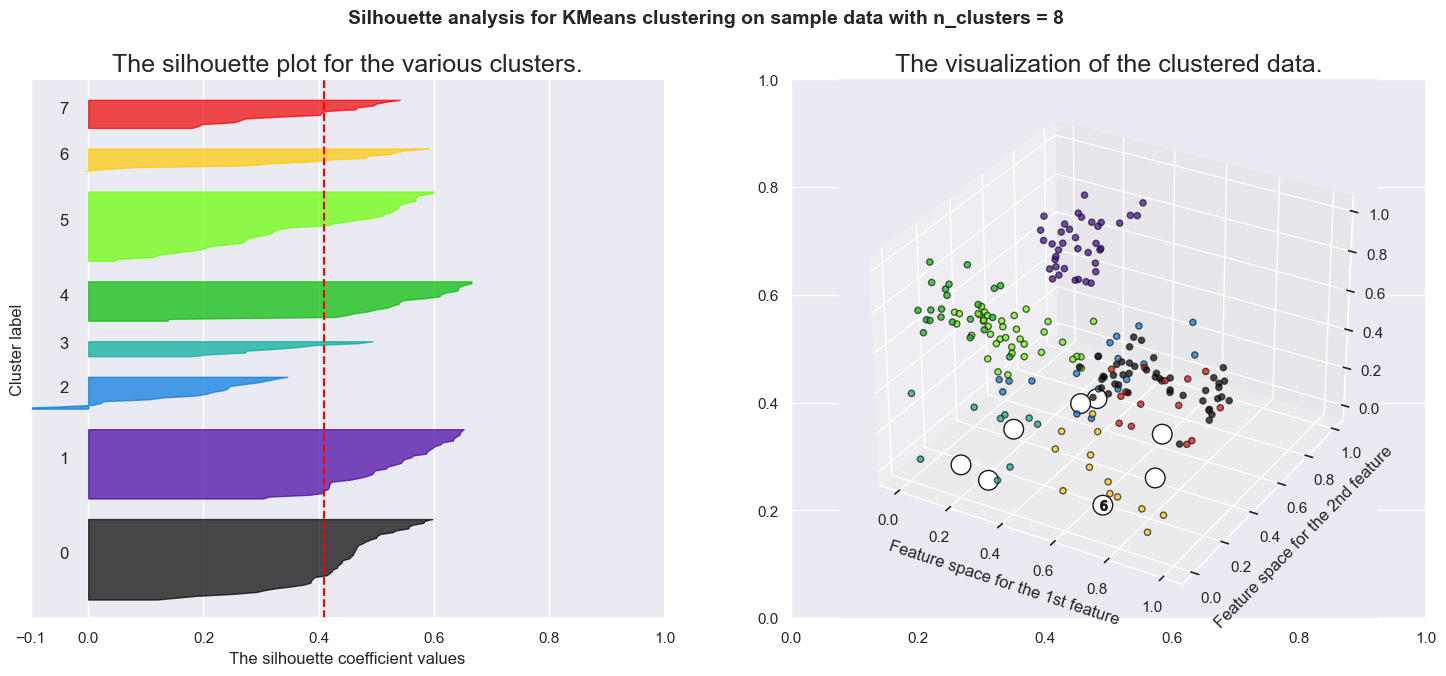

In [202]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import silhouette_samples, silhouette_score


range_n_clusters = [3, 4, 5, 6,7,8]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, df_scaled.shape[0] + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_seed)
    cluster_labels = clusterer.fit_predict(df_scaled)

    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(df_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax2 = fig.add_subplot(1, 2, 2, projection="3d")

    ax2.scatter3D(
        df_scaled[:,0],
        df_scaled[:,1],
        df_scaled[:,2],
        c=colors,
        cmap="nipy_spectral",
        alpha=0.7,
        edgecolor="k",
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Based on the results above, it can be observed that there is a clustering between "Annual Income" and "Spending Score (1-100)". If the silhouette_score is used as a metric, the optimal number of clusters would be 6.

In [203]:
km = KMeans(n_clusters=6, random_state=random_seed)
km.fit(df_scaled)


KMeans(n_clusters=6, random_state=42)

In [204]:
label = km.labels_
df_scaled_cluster = pd.DataFrame(label, columns=["cluster"])
df_scaled_cluster.value_counts().reset_index().sort_values("cluster")
                                

,cluster,count
3,0,29
4,1,23
5,2,19
2,3,39
1,4,43
0,5,45


### Summary

One interesting observation from the results above is the clustering between "Annual Income" and "Spending Score (1-100)". Let's take another look at the cluster results.

In [205]:
km = KMeans(n_clusters=5, random_state=random_seed)
km.fit(df_scaled[:,[1,2]])

KMeans(n_clusters=5, random_state=42)

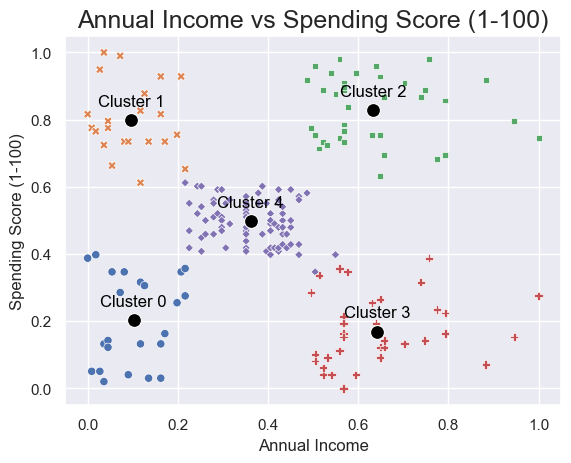

In [206]:
centroids = km.cluster_centers_
label = km.labels_

# Your existing scatterplot code
sns.scatterplot(x=df_scaled[:,1], y=df_scaled[:,2], hue=label, legend=False, style=label, palette="deep")
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], s = 100, c="black")
plt.title("Annual Income vs Spending Score (1-100)")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score (1-100)")

for i, centroid in enumerate(centroids):
    plt.annotate(f'Cluster {i}', (centroid[0], centroid[1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='black')

plt.show()


In [207]:
df_label = pd.DataFrame(label, columns=["cluster"])
df_label.value_counts().reset_index().sort_values("cluster")


,cluster,count
3,0,23
4,1,22
1,2,38
2,3,35
0,4,80


After clustering the data into 5 clusters, we found that clusters 1 and 2 have high spending scores and are particularly interesting. Cluster 1 consists of individuals with low income while cluster 2 consists of those with high income.

    cluster 1 : Low Income -> 22 Data
    cluster 2 : High Income -> 38 Data

Further analysis will be conducted to examine the age distribution within these two clusters.

In [208]:
df_numeric_cleaned["cluster"] = label

In [209]:
df_cluster_1 = df_numeric_cleaned[df_numeric_cleaned["cluster"]==1]
df_cluster_2 = df_numeric_cleaned[df_numeric_cleaned["cluster"]==2]

#### Cluster 1

##### Age

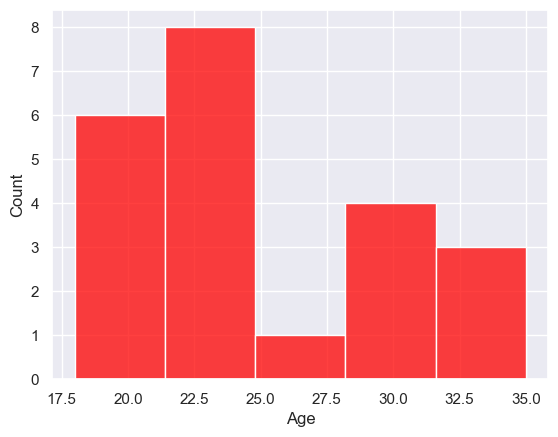

In [223]:
sns.histplot(df_cluster_1["Age"], color="red", bins=5)
plt.show()


In [217]:
print(f'min Age {df_cluster_1["Age"].min()} and max Age {df_cluster_1["Age"].max()}')

min Age 18 and max Age 35


##### Annual Income

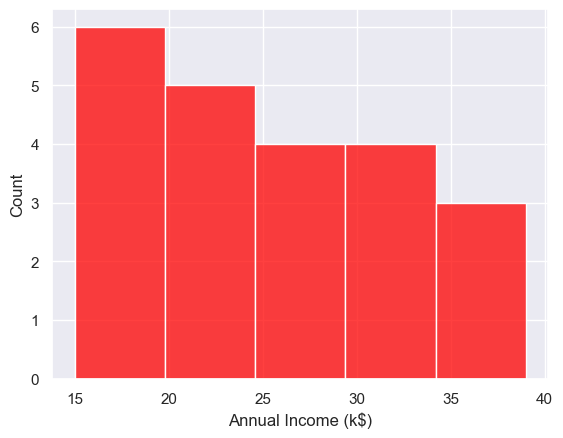

In [224]:
sns.histplot(df_cluster_1["Annual Income (k$)"], color="red", bins=5)
plt.show()

In [226]:
print(f'min Annual Income {df_cluster_1["Annual Income (k$)"].min()} and max Annual Income {df_cluster_1["Annual Income (k$)"].max()}')

min Annual Income 15 and max Annual Income 39


#### Cluster 2

##### Age

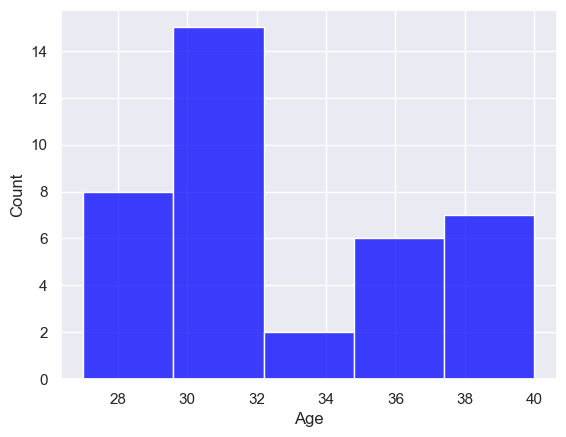

In [235]:
sns.histplot(df_cluster_2["Age"], color="blue", bins=5)
plt.show()


In [229]:
print(f'min Age {df_cluster_2["Age"].min()} and max Age {df_cluster_2["Age"].max()}')

min Age 27 and max Age 40


##### Annual Income

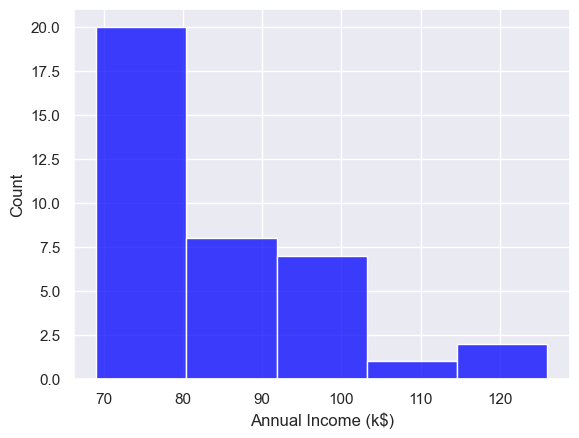

In [236]:
sns.histplot(df_cluster_2["Annual Income (k$)"], color="blue", bins=5)
plt.show()

In [231]:
print(f'min Annual Income {df_cluster_2["Annual Income (k$)"].min()} and max Annual Income {df_cluster_2["Annual Income (k$)"].max()}')

min Annual Income 69 and max Annual Income 126


#### Summary Points

* The customer who has high spending score is the customer who have age between **27-40** which is the most productive age and have annual income between 69-126k$.

* There is customer who has high spending score but low annual income, this customer is the customer who have age between 15-35 with annual incomme between 15-39k$.In particular the customer who have age under 25. This age is crucial age because this age is the age where the customer start to have their own income and start to have their own decision.